# Лабораторная работа: Рекомендательные системы

## Теоретическая часть

### 1. Суть задачи рекомендательных систем
Рекомендательные системы – это алгоритмы, которые анализируют поведение пользователей и предлагают персонализированные рекомендации товаров, фильмов, музыки и других объектов. Основная цель – предсказать предпочтения пользователей на основе имеющихся данных о взаимодействиях.


### 2. Метод коллаборативной фильтрации
Коллаборативная фильтрация (Collaborative Filtering, CF) – это метод рекомендаций, основанный на анализе поведения пользователей. Он работает на основе предположения, что пользователи с похожими предпочтениями в прошлом будут делать схожий выбор в будущем.

Существует два основных подхода:
1. **User-based CF** – рекомендации строятся на основе сходства пользователей.
2. **Item-based CF** – рекомендации строятся на основе сходства объектов.

### 3. Латентные факторные модели (Matrix Factorization)
Коллаборативная фильтрация может быть реализована через матричное разложение. Пусть у нас есть матрица взаимодействий пользователей и объектов R, где $( R_{u,i} )$ – оценка пользователя ( u ) для объекта ( i ). Тогда разложение можно представить в виде:
$$
R \approx U \cdot V^T
$$
где:
- ( U ) – матрица эмбеддингов пользователей,
- ( V ) – матрица эмбеддингов объектов.

Предсказание рейтинга рассчитывается как:
$$
\hat{R}_{u,i} = U_u \cdot V_i^T
$$

В данной лабораторной работе предполагается использование **нейросетевого метода**, который обучает эмбеддинги пользователей и объектов с помощью полносвязных слоев. Входные данные – индексы пользователей и объектов, которые преобразуются в векторные представления, а затем подаются на вход нейросети.


## Практическая часть
В данной работе вам предлагается реализовать рекомендательную систему на основе метода коллаборативной фильтрации, используя нейросетевую модель. Вы должны:
1. Подготовить данные: загрузить свой датасет (например, рейтинг фильмов, товаров, книг и т. д.).
2. Разбить данные на тренировочный и тестовый наборы.
3. Обучить модель, используя эмбеддинги пользователей и объектов.
4. Оценить качество модели на тестовом наборе.
5. Вывести список рекомендаций для выбранного пользователя.

In [38]:
# Импорты
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Определяем устройство (используем GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Датасет из 24 варианта - Рейтинг блюд

In [39]:
with open('ratings.csv', 'r', encoding='utf-8') as f:
    for _ in range(5):
        print(f.readline())

User_ID,Food_ID,Rating

1,88,4

1,46,3

1,24,5

1,25,4



In [40]:
# Определяем названия столбцов
df = pd.read_csv('ratings.csv', sep=',')
df.columns = ['user_id', 'food_id', 'rating']

In [41]:
# Подготовка данных
df = df.dropna(subset=['user_id', 'food_id', 'rating'])

df['user_id'] = df['user_id'].astype(int)
df['food_id'] = df['food_id'].astype(int)

df['user_id'] = pd.factorize(df['user_id'])[0].astype(int)
df['food_id'] = pd.factorize(df['food_id'])[0].astype(int)

print("Users min/max:", df['user_id'].min(), df['user_id'].max())
print("Items min/max:", df['food_id'].min(), df['food_id'].max())

Users min/max: 0 99
Items min/max: 0 308


In [42]:
# Определяем датасет PyTorch
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user_id'].values, dtype=torch.long)
        self.items = torch.tensor(df['food_id'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

In [44]:
# Определяем количество пользователей и блюд
num_users = df['user_id'].nunique()
num_items = df['food_id'].nunique()


В fc_layers добавлен Dropout для предотвращения переобучения

In [43]:
# Определяем нейросетевую модель для коллаборативной фильтрации
class RecommenderNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super(RecommenderNN, self).__init__()
        # Эмбеддинги пользователей и фильмов
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # Полносвязные слои для предсказания рейтинга
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, user, item):
        # Получаем эмбеддинги пользователя и фильма
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)

        # Объединяем эмбеддинги
        x = torch.cat([user_emb, item_emb], dim=1)

        # Пропускаем через полносвязные слои
        return self.fc_layers(x).squeeze()

In [45]:
# Создаём датасеты и загрузчики данных
dataset = RatingsDataset(df)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

Попробовав разные embedding_dim, лучшим оказалось значение 32

In [59]:
# Инициализация модели
model = RecommenderNN(num_users, num_items, 256).to(device)

# Определяем функцию потерь (MSE) и оптимизатор (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)

Epoch 1: Train Loss=23.8110, Val Loss=11.0433
Epoch 2: Train Loss=8.3179, Val Loss=13.1295
Epoch 3: Train Loss=5.3164, Val Loss=13.6836
Epoch 4: Train Loss=3.4029, Val Loss=13.3490
Epoch 5: Train Loss=2.1521, Val Loss=13.4831


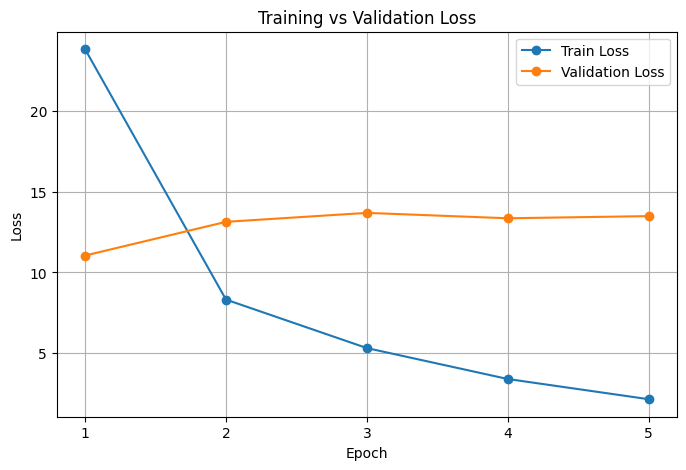


Test RMSE: 3.6272, Test MAE: 2.9880

Recommendations for random users:
User 53: Recommended items [267 295  10 246 168]
User 51: Recommended items [201 267 295  10 284]
User 10: Recommended items [ 10  53 267 295  42]
User 53: Recommended items [267 295  10 246 168]
User 94: Recommended items [ 10 267  66 295  34]


In [60]:
train_losses = []
val_losses = []

for epoch in range(5):
    model.train()
    total_train_loss = 0

    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)

        optimizer.zero_grad()
        predictions = model(users, items)

        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    train_loss_epoch = total_train_loss / len(train_loader)
    train_losses.append(train_loss_epoch)

    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for users, items, ratings in test_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)

            predictions = model(users, items)
            loss = criterion(predictions, ratings)

            total_val_loss += loss.item()

    val_loss_epoch = total_val_loss / len(test_loader)
    val_losses.append(val_loss_epoch)

    print(f"Epoch {epoch+1}: Train Loss={train_loss_epoch:.4f}, Val Loss={val_loss_epoch:.4f}")

plt.figure(figsize=(8,5))

plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='o', label='Validation Loss')

plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, len(train_losses)+1))
plt.legend()
plt.grid(True)

plt.show()

# Оценка модели на тестовом наборе
model.eval()
test_predictions = []
test_ratings = []
with torch.no_grad():
    for users, items, ratings in test_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        predictions = model(users, items)
        test_predictions.extend(predictions.cpu().numpy())
        test_ratings.extend(ratings.cpu().numpy())

# Средняя ошибка на тестовом наборе
test_rmse = math.sqrt(mean_squared_error(test_ratings, test_predictions))
test_mae = mean_absolute_error(test_ratings, test_predictions)

print(f'\nTest RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')

# Рекомендации для нескольких случайных пользователей
random_users = np.random.choice(df['user_id'].unique(), size=5)

print("\nRecommendations for random users:")
for user_id in random_users:
    # Предсказания для всех объектов для выбранного пользователя
    user_tensor = torch.tensor([user_id] * num_items, dtype=torch.long).to(device)
    item_tensor = torch.tensor(range(num_items), dtype=torch.long).to(device)

    with torch.no_grad():
        predictions = model(user_tensor, item_tensor).cpu().numpy()

    # Выбираем топ-5 рекомендованных объектов
    top_items = predictions.argsort()[-5:][::-1]

    print(f"User {user_id + 1}: Recommended items {top_items + 1}")

На первых трёх эпохах происходит уменьшение функции потерь как на обучающей, так и на тестовой выборке, что свидетельствует об успешном обучении модели.
Однако начиная с 4-й эпохи значение функции потерь на обучающей выборке продолжает уменьшаться, в то время как на тестовой выборке наблюдаются колебания без снижения.
Это свидетельствует о начале переобучения модели.